In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
full_db = '/Users/kennyquintana/Desktop/merged_sites.xlsx'
flowline_sources = ['NHD', 'TDX']
streamflow_sources = ['NWM', 'GEO']

# 1. Read Sites and Filter
sites_df = pd.read_excel(full_db, sheet_name='Sites')
# sites_clean = sites_df[sites_df['comments'].isna()]
sites_clean = sites_df.copy()

# List to store stats for plotting
plot_data = []

for flowline in flowline_sources:
    for streamflow in streamflow_sources:
        # Read in the hydraulic results
        sheet_name = f'Results{flowline}{streamflow}'
        results_df = pd.read_excel(full_db, sheet_name=sheet_name)

        # Filter to good sites
        results_sites = results_df[results_df['site_id'].isin(sites_clean['site_id'])]

        # Filter out bad dam height predictions (Use results_sites, not results_df!)
        results_valid = results_sites.dropna(subset=['jump_type'])

        total_valid = len(results_valid)
        combo_label = f"{flowline}-{streamflow}"

        print(f'Processing {combo_label} ({total_valid} valid results)...')

        for i in range(1, 5):
            xs_i = results_valid[results_valid['xs_index'] == i]
            valid_i = len(xs_i)

            # Avoid division by zero
            if valid_i == 0:
                continue

            # Calculate Counts
            # (Using the corrected boolean summing method)
            type_a = (xs_i['jump_type'] == 'A').sum()
            type_c = (xs_i['jump_type'] == 'C').sum()
            type_d = (xs_i['jump_type'] == 'D').sum()

            # Store data for plotting (focusing on A, C, D)
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type A', 'percentage': (type_a / valid_i * 100), 'count': type_a})
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type C', 'percentage': (type_c / valid_i * 100), 'count': type_c})
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type D', 'percentage': (type_d / valid_i * 100), 'count': type_d})


Processing NHD-NWM (1415 valid results)...
Processing NHD-GEO (1380 valid results)...
Processing TDX-NWM (1194 valid results)...
Processing TDX-GEO (1539 valid results)...


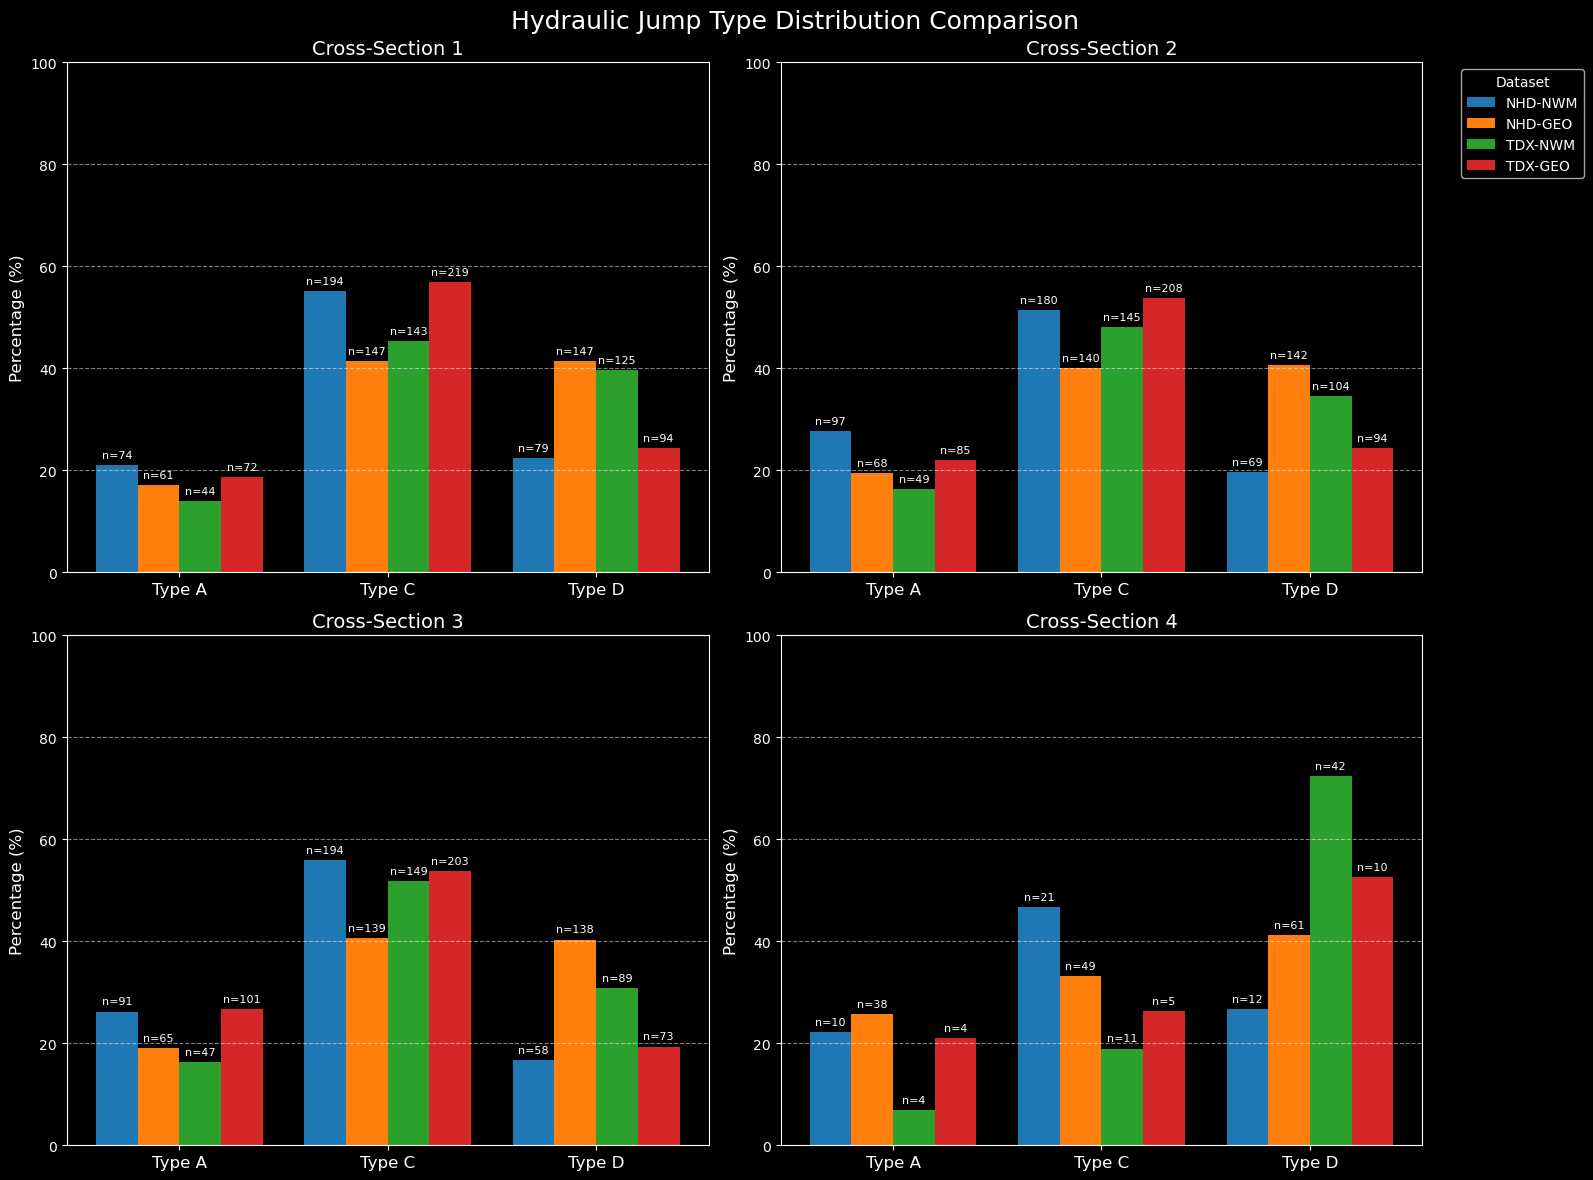

In [14]:
# --- PLOTTING ---
df_plot = pd.DataFrame(plot_data)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

jump_types = ['Type A', 'Type C', 'Type D']
combinations = df_plot['Combination'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Blue, Orange, Green, Red
bar_width = 0.2
x = np.arange(len(jump_types))

for i, xs in enumerate(range(1, 5)):
    ax = axes[i]
    subset_xs = df_plot[df_plot['xs_index'] == xs]

    for j, combo in enumerate(combinations):
        subset_combo = subset_xs[subset_xs['Combination'] == combo]

        # Extract heights in strict order
        heights = []
        counts = []
        for jt in jump_types:
            row = subset_combo[subset_combo['jump_type'] == jt]
            heights.append(row['percentage'].values[0] if not row.empty else 0)
            counts.append(row['count'].values[0] if not row.empty else 0)

        # Center bars around the tick
        pos = x + (j - 1.5) * bar_width
        bars = ax.bar(pos, heights, bar_width, label=combo, color=colors[j])

        # Add counts on top of bars
        for bar, count in zip(bars, counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'n={int(count)}',
                        ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_title(f'Cross-Section {xs}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(jump_types, fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    if i == 1:
        ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Hydraulic Jump Type Distribution Comparison', fontsize=18)
plt.tight_layout()
plt.show()